<a href="https://colab.research.google.com/github/shamith09/kaggle-titanic-challenge/blob/master/Titanic_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run on TensorFlow 2.x
%tensorflow_version 2.x

In [9]:
#@title Load the imports

# from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

Ran the import statements.


In [10]:
#@title Upload train.csv
from google.colab import files
uploaded = files.upload() # train.csv

Saving train.csv to train.csv


In [11]:
#@title Upload test.csv
from google.colab import files
uploaded2 = files.upload() # train.csv

Saving test.csv to test.csv


In [12]:
#@title Read train.csv and test.csv into pandas DataFrames.
import io
train_df = pd.read_csv(io.BytesIO(uploaded['train.csv']))
test_df = pd.read_csv(io.BytesIO(uploaded2['test.csv']))
train_df = train_df.reindex(np.random.permutation(train_df.index)) # shuffle the training set

print(train_df)

     PassengerId  Pclass     Sex  Age  SibSp  Parch  Fare Embarked  Survived
206          207       3    male 32.0      1      0  15.8        S         0
320          321       3    male 22.0      0      0   7.2        S         0
235          236       3  female  nan      0      0   7.5        S         0
282          283       3    male 16.0      0      0   9.5        S         0
363          364       3    male 35.0      0      0   7.0        S         0
..           ...     ...     ...  ...    ...    ...   ...      ...       ...
294          295       3    male 24.0      0      0   7.9        S         0
602          603       1    male  nan      0      0  42.4        S         0
144          145       2    male 18.0      0      0  11.5        S         0
605          606       3    male 36.0      1      0  15.6        S         0
106          107       3  female 21.0      0      0   7.7        S         1

[891 rows x 9 columns]


In [0]:
#@title Remove rows with any empty, null, or NaN values.
train_df.replace('', np.nan, inplace=True)
train_df.dropna(inplace=True)

In [0]:
#@title Normalize the age and fare columns.
for column in train_df:
    if column == 'Age':
        train_df[column] = train_df[column] / 80
    elif column == 'Fare':
        train_df[column] = train_df[column] / 512.3292

In [0]:
#@title Convert sex and embarked columns to numeric values.
train_df['Sex'][train_df['Sex'] == 'male'] = 0
train_df['Sex'][train_df['Sex'] == 'female'] = 1

train_df['Embarked'][train_df['Embarked'] == 'S'] = -1
train_df['Embarked'][train_df['Embarked'] == 'C'] = 0
train_df['Embarked'][train_df['Embarked'] == 'Q'] = 1

In [0]:
#@title Define and add the features to a DenseFeatures layer.
feature_columns = []
feature_names = [
      'Sex',
      'Age',
      'Parch',
      'SibSp',
      'Fare'
]

for name in feature_names:
  fcolumn = tf.feature_column.numeric_column(name)
  feature_columns.append(fcolumn)

feature_layer = layers.DenseFeatures(feature_columns)

In [86]:
#@title Define the functions that create and train a model.
def create_model(my_learning_rate, feature_layer, my_metrics, lmbda):
  """Create and compile a simple classification model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the feature layer (the list of features and how they are represented)
  # to the model.
  model.add(feature_layer)

  # Funnel the regression value through a sigmoid function.
  model.add(layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(lmbda)))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))

  # Call the compile method to construct the layers into a model that
  # TensorFlow can execute.  Notice that we're using a different loss
  # function for classification than for regression.    
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

  return model        


def train_model(model, dataset, epochs, label_name,
                batch_size=None, shuffle=True):
  """Feed a dataset into the model in order to train it."""

  # The x parameter of tf.keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.  Here, we're passing
  # every column in the dataset. Note that the feature_layer will filter
  # away most of those columns, leaving only the desired columns and their
  # representations as features.
  features = {name:np.array(value, np.float32) for name, value in dataset.items()}
  label = np.array(features.pop(label_name)) 
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle)
  
  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch

  # Isolate the classification metric for each epoch.
  hist = pd.DataFrame(history.history)

  return epochs, hist  

print("Defined the create_model and train_model functions.")   

Defined the create_model and train_model functions.


Epoch 1/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7823 - accuracy: 0.7121
Epoch 2/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7673 - accuracy: 0.7753
Epoch 3/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7536 - accuracy: 0.7879
Epoch 4/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7399 - accuracy: 0.7935
Epoch 5/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7265 - accuracy: 0.7865
Epoch 6/150
23/23 [==============================] - 0s 2ms/step - loss: 0.7123 - accuracy: 0.7921
Epoch 7/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.7949
Epoch 8/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6849 - accuracy: 0.7865
Epoch 9/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6711 - accuracy: 0.7921
Epoch 10/150
23/23 [==============================] - 0s 2ms/step - loss: 0.6572 - accuracy: 0.7865
Epoch 11/

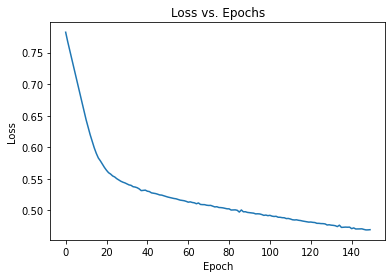

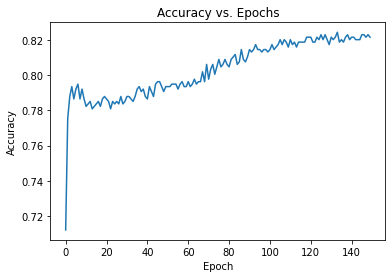

In [88]:
#@title Train the model and plot the loss and accuracy curves.
# The following variables are the hyperparameters.
learning_rate = 0.0001
epochs = 150
batch_size = 32
lmbda = 0.01
label_name = 'Survived'
classification_threshold = 0.5

# Establish the metrics the model will measure.
METRICS = [
           tf.keras.metrics.BinaryAccuracy(name='accuracy', 
                                           threshold=classification_threshold),
          ]

# Establish the model's topography.
my_model = create_model(learning_rate, feature_layer, METRICS, lmbda)

# Train the model on the training set.
epochs, hist = train_model(my_model, train_df, epochs, 
                           label_name, batch_size)

# Plot a graph of the metric(s) vs. epochs.
list_of_metrics_to_plot = ['accuracy']

# plot_curve(epochs, hist, list_of_metrics_to_plot)
loss = hist['loss']
acc = hist['accuracy']

plt.plot(epochs, loss)
plt.title('Loss vs. Epochs')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.plot(epochs, acc)
plt.title('Accuracy vs. Epochs')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()  

In [0]:
#@title Delete the .csv files.
!rm -rf train.csv
!rm -rf test.csv